In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# 🚆 Railway Maintenance Priority Classifier

## 🧠 Project Overview

In this notebook, we build a neural network classifier using **PyTorch** to predict the **priority level** (Low, Medium, High) of railway maintenance tasks based on various task features. The goal is to assist railway operations in **automated decision-making** and **resource prioritization**.

---

## 📊 Dataset Description

The dataset `fake_railway_maintenance_data.csv` contains **synthetic** records of railway maintenance operations. It includes several numeric and categorical features that describe each task, such as distance, duration, and infrastructure condition.

- **Input**: Features (numerical/categorical)
- **Target**: `priority` → Class labels: Low, Medium, High



In [9]:

df = pd.read_csv('/content/fake_railway_maintenance_data.csv')

X = df.drop(columns=['priority']).values
y = df['priority'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class RailDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = RailDataset(X_train, y_train)
test_ds = RailDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x): return self.net(x)

model = Classifier(input_dim=X.shape[1])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



## 🔁 Training Loop & 📉 Loss Visualization

### Model Training
We train the model for **20 epochs** using the training data loader. In each epoch:

- The model is set to training mode.
- For each batch:
  - We perform a forward pass to get predictions.
  - Compute the **Cross-Entropy Loss** between predictions and ground truth labels.
  - Use **backpropagation** to compute gradients.
  - Apply the **Adam optimizer** to update weights.
- We track the **average loss per epoch** to monitor learning progress.



Epoch 1/20, Loss: 0.7949
Epoch 2/20, Loss: 0.2727
Epoch 3/20, Loss: 0.1838
Epoch 4/20, Loss: 0.1499
Epoch 5/20, Loss: 0.1289
Epoch 6/20, Loss: 0.1121
Epoch 7/20, Loss: 0.0994
Epoch 8/20, Loss: 0.0934
Epoch 9/20, Loss: 0.0837
Epoch 10/20, Loss: 0.0783
Epoch 11/20, Loss: 0.0725
Epoch 12/20, Loss: 0.0732
Epoch 13/20, Loss: 0.0645
Epoch 14/20, Loss: 0.0618
Epoch 15/20, Loss: 0.0545
Epoch 16/20, Loss: 0.0523
Epoch 17/20, Loss: 0.0531
Epoch 18/20, Loss: 0.0532
Epoch 19/20, Loss: 0.0492
Epoch 20/20, Loss: 0.0435


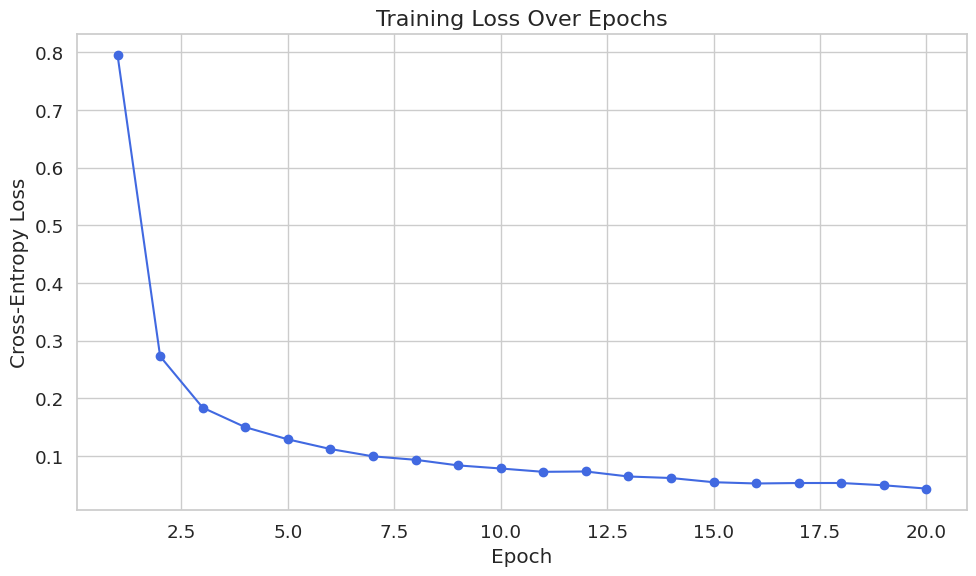

In [10]:
loss_history = []

for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/20, Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), loss_history, marker='o', color='royalblue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

model.eval()
all_preds = []
all_targets = []
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        predicted = torch.argmax(preds, dim=1)
        all_preds.extend(predicted.numpy())
        all_targets.extend(y_batch.numpy())
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)



In [11]:
print(f"Test Accuracy: {correct / total:.2%}")

Test Accuracy: 97.25%


## 📊 Confusion Matrix Visualization

The **confusion matrix** provides a deeper look into the performance of our classifier by showing how often actual classes are predicted correctly — and where the model makes mistakes.

- Rows represent the **true labels**.
- Columns represent the **predicted labels**.
- Diagonal values indicate correct predictions.
- Off-diagonal values show misclassifications.

This is especially useful in multiclass problems like this one, where we predict task **priority levels**: `Low`, `Medium`, and `High`.


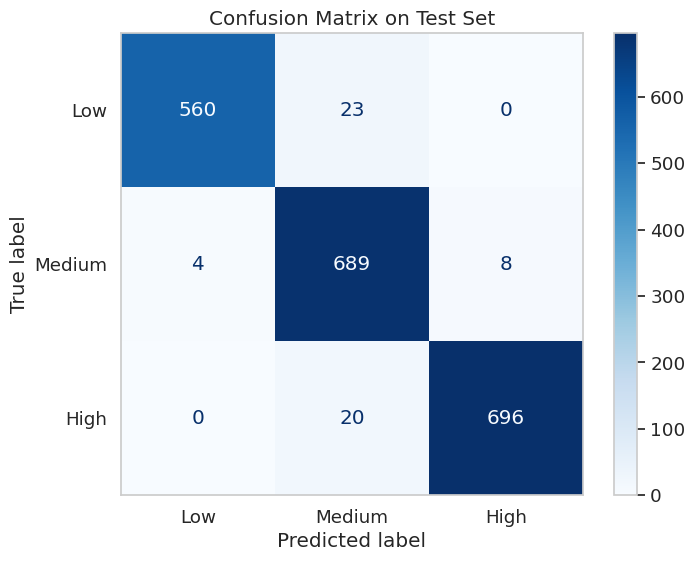

In [12]:
cm = confusion_matrix(all_targets, all_preds)
labels = ['Low', 'Medium', 'High']  # update based on actual label meanings
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title('Confusion Matrix on Test Set')
plt.grid(False)
plt.show()

In [13]:
import pickle

with open("priority_classifier_model.pkl", "wb") as f:
    pickle.dump(model, f)
